# 11.11.2 Changing the initial state

In this notebook, the numerical computation of the Kolmogorov formula is considered with changes of the initial state(s) at predefined dates. 

In the following we consider the same *system* as in the notebook `11_09_TimeDependentSolution` where states are defined as:
- State 2: Normal operating state
- State 1: Degraded operating state
- State 0: Failure state

and where $\lambda_{i,j}$ is the transition rate from state $i$ to state $j$. Therefore, $\lambda_{2,1}$ and $\lambda_{1,0}$ should be considered as degradation rates.

Comparing to the notebook `11_09_TimeDependentSolution` where $\lambda_{0,2}$ corresponded to a renewing rate, here we don't consider anymore a corrective maintenance but instead a periodic one. Therefore, according to the scheme bellow, the transition associated to $\lambda_{0,2}$ is removed and replaced by dotted lines that show that the periodic maintenance might be unperfect and may also leads, with a low probabilities, to the degradation and even to the failure of the system. 

![](./../../images/Schema_11_11_02.png)

In the following we consider that the duration of the periodic maintenance is deterministic and that the quality of the maintenance is improved (probabilities of system degradation during the maintenance are going down) year to year. As in notebook `11_09_TimeDependentSolution`, the initial state at the beginning of the *simulation* is state 2. 

Notation: probabilities of maintenance effects $p_{i,j}$, alias `p_ij` in the code below, correpond to the probabilities that the system in state $i$ at the maintenance beginning would be in state $j$ at the maintenance end. In the script below, probabilities $p_{i,2}$ are deduced from $p_{i,1}$ and $p_{i,0}$ ($p_{i,2}+p_{i,1}+p_{i,0}=1$).

The maintenance improvement ratio $k$, alias `y2y_rat`, is defined in such way that probabilites $p_{i,1}$ at year $y$ defined as $p_{i,1}^{(y)}$ correspond to $p_{i,1}^{(y)} = k\,p_{i,1}^{(y-1)}$ for $i=1,2,3$

### Import

In [1]:
import numpy as np
from scipy.linalg import expm

%matplotlib notebook
import matplotlib.pyplot as plt

import pdb

### Parameters

In [2]:
# Transition rates (1/h)
lambda_21 = 1e-4
lambda_10 = 1e-4
# Time (h)
t_start = 0
t_end = 24*365*5
t_nstep = 10000
# Periodic maintenance duration (h)
maint_per = 24*365
# Maintenance period (h)
maint_dur = 24*14
# Maintenance effects probabilities
p_00 = 1e-3
p_01 = 1e-1
p_10 = 1e-3
p_11 = 1e-2
p_20 = 1e-3 # 0.99 # 1e-3
p_21 = 0
# Maintenance improvement (lower is the coefficient, better is the maintenance)
y2y_rat = 0.5
# Initial state
state0 = 2

### Equation variables

In [3]:
# matrix A
A = np.array([
    [0, 0, 0],
    [lambda_10, -lambda_10, 0],
    [0, lambda_21, -lambda_21]])
# initial system state
P0 = np.zeros((3, ))
P0[state0] = 1
# time vector
t = np.linspace(t_start, t_end, t_nstep)

### Numerical computation

In [4]:
P = np.zeros((3, t_nstep))
for it in range(t_nstep):
    nMaint = int(t[it]//maint_per)
    if nMaint==0:
        P[:, it] = P0@expm(A*t[it])
    else:
        if (t[it]-nMaint*maint_per)<=maint_dur:
            P[:, it] = np.zeros((3, ))
        else:
            M = np.eye(A.shape[0])
            for im in range(0, nMaint):
                B = np.array([
                    [p_00, p_01*(y2y_rat**im), 1-(p_00+p_01*(y2y_rat**im))],
                    [p_10, p_11*(y2y_rat**im), 1-(p_10+p_11*(y2y_rat**im))],
                    [p_20, p_21*(y2y_rat**im), 1-(p_20+p_21*(y2y_rat**im))]])
                M = M@expm(A*maint_per)@B
            P[:, it] = P0@M@expm(A*(t[it]-(nMaint*maint_per+maint_dur)))

### Illustration

<IPython.core.display.Javascript object>


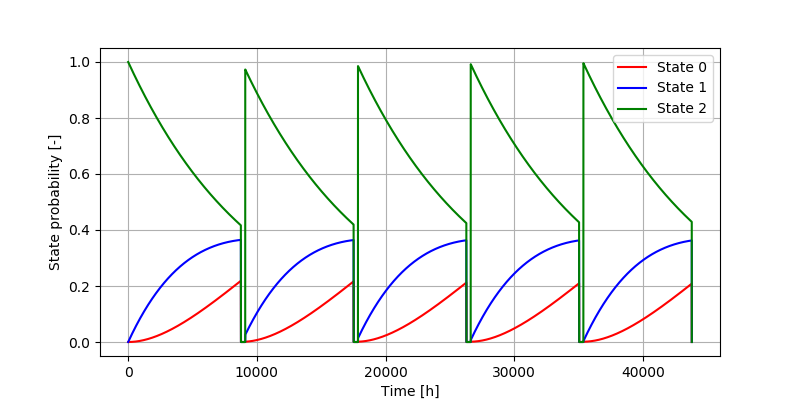

In [5]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
vColor = ['r', 'b', 'g']
for jd in range(3):
    ax.plot(t, P[jd, :], color=vColor[jd], label='State {:d}'.format(jd))
ax.set_xlabel('Time [h]')
ax.set_ylabel('State probability [-]')
ax.legend()
ax.grid(True)